# 🎯 Thought Anchor Results Viewer

이미지 + 문제 + 추론 결과 + Thought Anchor 랭킹을 한눈에 확인

In [1]:
import json
import numpy as np
from pathlib import Path
from PIL import Image
from IPython.display import display, HTML, Markdown
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import textwrap

In [2]:
def display_result(json_path):
    """단일 결과 파일을 이미지와 함께 표시"""
    with open(json_path, 'r', encoding='utf-8') as f:
        data = json.load(f)
    
    example_name = json_path.stem
    
    # 헤더
    display(HTML(f"""
        <div style="background: linear-gradient(135deg, #667eea 0%, #764ba2 100%);
                    color: white; padding: 15px; border-radius: 10px; margin-bottom: 20px;">
            <h2 style="margin: 0;">📊 {example_name.upper()}</h2>
        </div>
    """))
    
    # 에러 체크
    if 'error' in data:
        display(HTML(f"""
            <div style="background: #ffebee; color: #c62828; padding: 15px; 
                        border-left: 4px solid #f44336; border-radius: 5px;">
                ❌ Error: {data['error']}
            </div>
        """))
        return
    
    if data.get('successful_pairs', 0) == 0:
        display(HTML("""
            <div style="color: #999; font-style: italic; padding: 20px; text-align: center;">
                ⚠️ No successful QA pairs
            </div>
        """))
        return
    
    # 이미지 로드
    image_path = data.get('image_path')
    image = None
    if image_path and Path(image_path).exists():
        try:
            image = Image.open(image_path)
        except Exception as e:
            print(f"Failed to load image: {e}")
    
    # 각 QA pair 처리
    for qa_idx, qa_pair in enumerate(data.get('qa_pairs', [])):
        display(HTML(f"""
            <div style="background: #f5f5f5; padding: 10px; margin: 20px 0; 
                        border-radius: 5px; font-weight: bold;">
                QA Pair {qa_idx + 1}
            </div>
        """))
        
        # 레이아웃: 이미지 + 텍스트
        fig = plt.figure(figsize=(16, 8))
        
        # 왼쪽: 이미지
        ax_img = plt.subplot(1, 2, 1)
        if image is not None:
            ax_img.imshow(image)
            ax_img.axis('off')
            ax_img.set_title('Image', fontsize=14, fontweight='bold', pad=10)
        else:
            ax_img.text(0.5, 0.5, 'No Image Available', 
                       ha='center', va='center', fontsize=14, color='gray')
            ax_img.set_xlim(0, 1)
            ax_img.set_ylim(0, 1)
            ax_img.axis('off')
        
        # 오른쪽: 텍스트 (Question + Reasoning)
        ax_text = plt.subplot(1, 2, 2)
        ax_text.axis('off')
        
        # Question
        question = qa_pair.get('question', '')
        if '<|vision_start|>' in question:
            question = question.split('\n')[-1]
        
        # Reasoning
        reasoning = qa_pair.get('reasoning_text', '')
        
        # 텍스트 박스 생성
        y_pos = 0.95
        
        # Question 박스
        ax_text.add_patch(Rectangle((0, y_pos - 0.15), 1, 0.15, 
                                    facecolor='#e3f2fd', edgecolor='#2196f3', linewidth=2))
        ax_text.text(0.02, y_pos - 0.02, '❓ Question:', 
                    fontsize=12, fontweight='bold', color='#1976d2')
        
        wrapped_q = '\n'.join(textwrap.wrap(question, width=60))
        ax_text.text(0.02, y_pos - 0.05, wrapped_q, 
                    fontsize=10, verticalalignment='top')
        
        y_pos -= 0.20
        
        # Reasoning 박스
        reasoning_height = 0.65
        ax_text.add_patch(Rectangle((0, y_pos - reasoning_height), 1, reasoning_height, 
                                    facecolor='#f3e5f5', edgecolor='#9c27b0', linewidth=2))
        ax_text.text(0.02, y_pos - 0.02, '💭 Reasoning:', 
                    fontsize=12, fontweight='bold', color='#7b1fa2')
        
        # Reasoning 파싱
        reasoning_lines = []
        if '<SUMMARY>' in reasoning:
            # LLaVA-CoT 형식
            for tag in ['SUMMARY', 'CAPTION', 'REASONING', 'CONCLUSION']:
                if f'<{tag}>' in reasoning and f'</{tag}>' in reasoning:
                    start = reasoning.find(f'<{tag}>') + len(f'<{tag}>')
                    end = reasoning.find(f'</{tag}>')
                    content = reasoning[start:end].strip()
                    reasoning_lines.append(f'<{tag}> {content}')
        else:
            # <think> 형식
            reasoning_lines = reasoning.split('\n')
        
        # 텍스트 줄바꿈 및 표시
        y_text = y_pos - 0.05
        for line in reasoning_lines:
            if line.strip():
                wrapped = textwrap.wrap(line, width=60)
                for wrap_line in wrapped:
                    ax_text.text(0.02, y_text, wrap_line, 
                               fontsize=9, verticalalignment='top')
                    y_text -= 0.03
                    if y_text < 0.05:
                        break
                if y_text < 0.05:
                    break
        
        ax_text.set_xlim(0, 1)
        ax_text.set_ylim(0, 1)
        
        plt.tight_layout()
        plt.show()
        
        # Thought Anchor Rankings
        chunks = qa_pair.get('chunks', [])
        anchor_vector = qa_pair.get('anchor_vector', [])
        
        if len(chunks) > 0 and len(anchor_vector) > 0:
            # Anchor 정렬
            anchor_pairs = list(zip(range(len(chunks)), chunks, anchor_vector))
            anchor_pairs.sort(key=lambda x: x[2], reverse=True)
            
            # Top 5만
            top_anchors = anchor_pairs[:5]
            
            display(HTML("""
                <div style="background: #fff; padding: 15px; border-radius: 10px; 
                            border: 2px solid #667eea; margin-top: 20px;">
                    <h3 style="color: #667eea; margin-top: 0;">🏆 Thought Anchor Rankings</h3>
                </div>
            """))
            
            if any(score > 0 for _, _, score in top_anchors):
                for rank, (chunk_idx, chunk, score) in enumerate(top_anchors, 1):
                    # 텍스트 정리
                    text = chunk.replace('<reasoning>', '').replace('</reasoning>', '')
                    text = text.replace('<think>', '').replace('</think>', '')
                    text = text.replace('<final>', '').replace('</final>', '')
                    text = text.replace('<SUMMARY>', '').replace('</SUMMARY>', '')
                    text = text.replace('<CAPTION>', '').replace('</CAPTION>', '')
                    text = text.replace('<REASONING>', '').replace('</REASONING>', '')
                    text = text.replace('<CONCLUSION>', '').replace('</CONCLUSION>', '')
                    text = text.strip()
                    
                    # 색상 선택
                    colors = {
                        1: ('#ffebee', '#f44336'),
                        2: ('#fff3e0', '#ff9800'),
                        3: ('#fffde7', '#ffc107'),
                        4: ('#e8f5e9', '#4caf50'),
                        5: ('#e3f2fd', '#2196f3')
                    }
                    bg_color, border_color = colors.get(rank, ('#f5f5f5', '#999'))
                    
                    display(HTML(f"""
                        <div style="background: {bg_color}; padding: 12px; margin: 10px 0; 
                                    border-left: 5px solid {border_color}; border-radius: 5px;">
                            <div style="display: flex; justify-content: space-between; 
                                        align-items: center; margin-bottom: 5px;">
                                <strong style="font-size: 16px;">Rank {rank} (Sentence {chunk_idx}):</strong>
                                <span style="background: rgba(0,0,0,0.1); padding: 3px 10px; 
                                            border-radius: 12px; font-size: 14px;">
                                    Score: {score:.4f}
                                </span>
                            </div>
                            <div style="color: #555; font-size: 14px;">
                                Text: "{text}"
                            </div>
                        </div>
                    """))
            else:
                display(HTML("""
                    <div style="color: #999; font-style: italic; padding: 20px; text-align: center;">
                        ⚠️ All anchor scores are zero (attention masking may have failed)
                    </div>
                """))
        else:
            display(HTML("""
                <div style="color: #999; font-style: italic; padding: 20px; text-align: center;">
                    ⚠️ No chunks or anchor scores available
                </div>
            """))
        
        # 구분선
        display(HTML('<hr style="border: 1px solid #ddd; margin: 40px 0;">'))

## 📂 결과 파일 목록

In [3]:
output_dir = Path('anchor_vectors_output')
result_files = sorted(output_dir.glob('example_*.json'))

print(f"총 {len(result_files)}개의 결과 파일:")
for i, f in enumerate(result_files):
    size_kb = f.stat().st_size / 1024
    with open(f, 'r') as jf:
        data = json.load(jf)
        status = "✅" if data.get('successful_pairs', 0) > 0 else "❌"
    print(f"  {i}. {status} {f.name} ({size_kb:.1f} KB)")

총 10개의 결과 파일:
  0. ❌ example_0.json (0.2 KB)
  1. ✅ example_1.json (4.7 KB)
  2. ❌ example_2.json (0.2 KB)
  3. ❌ example_3.json (0.2 KB)
  4. ❌ example_4.json (0.2 KB)
  5. ✅ example_5.json (2.6 KB)
  6. ✅ example_6.json (0.9 KB)
  7. ❌ example_7.json (0.2 KB)
  8. ✅ example_8.json (2.7 KB)
  9. ✅ example_9.json (1.3 KB)


## 🎯 성공한 예제만 자동으로 표시

성공한 예제: 5개



/tmp/ipykernel_2217262/2668886646.py:133: UserWarning: Glyph 10067 (\N{BLACK QUESTION MARK ORNAMENT}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_2217262/2668886646.py:133: UserWarning: Glyph 128173 (\N{THOUGHT BALLOON}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/home/jyko/miniforge3/envs/mm1/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 10067 (\N{BLACK QUESTION MARK ORNAMENT}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/jyko/miniforge3/envs/mm1/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128173 (\N{THOUGHT BALLOON}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


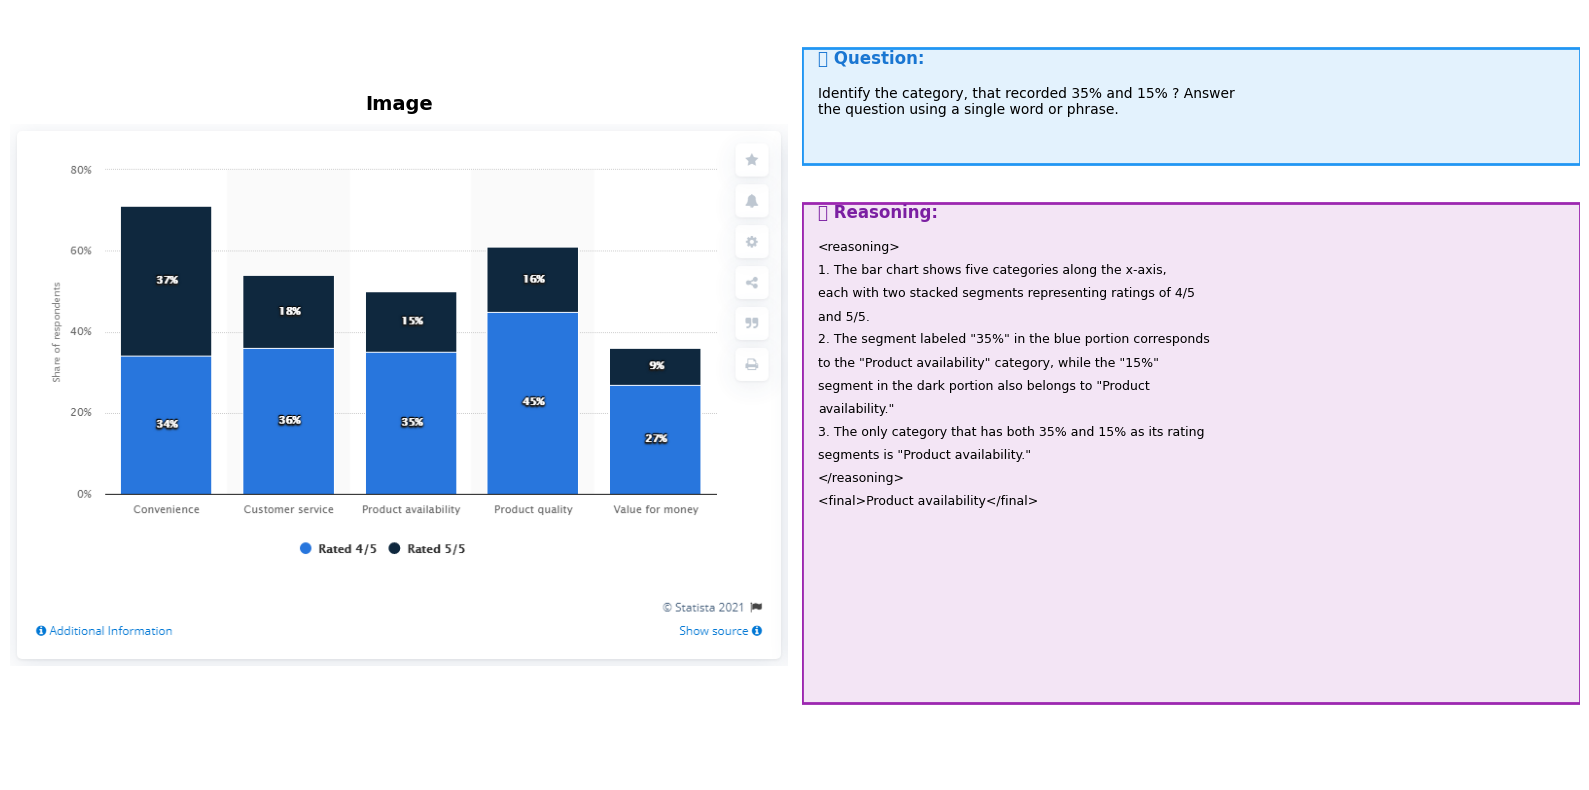

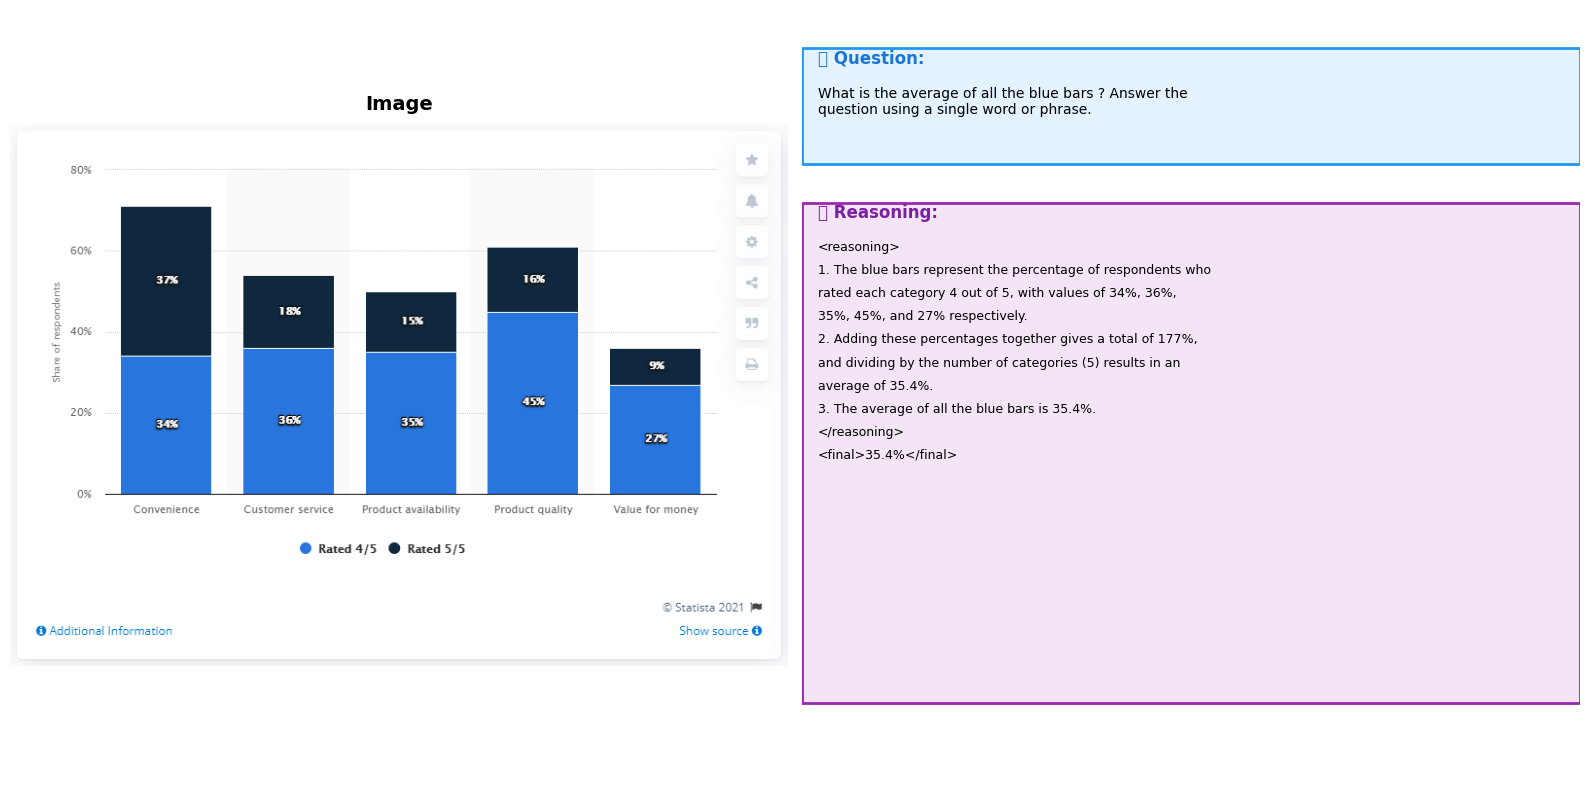

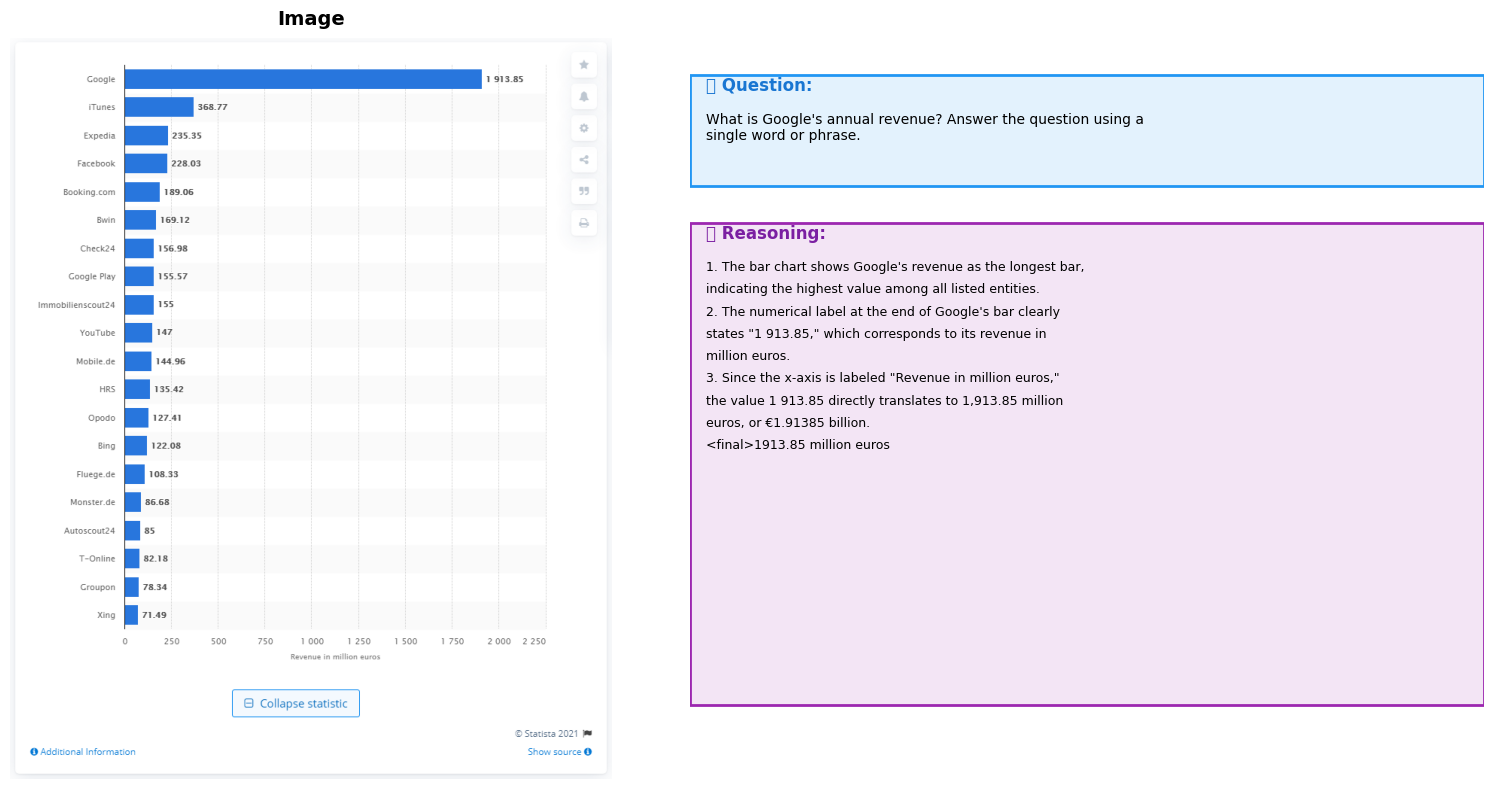

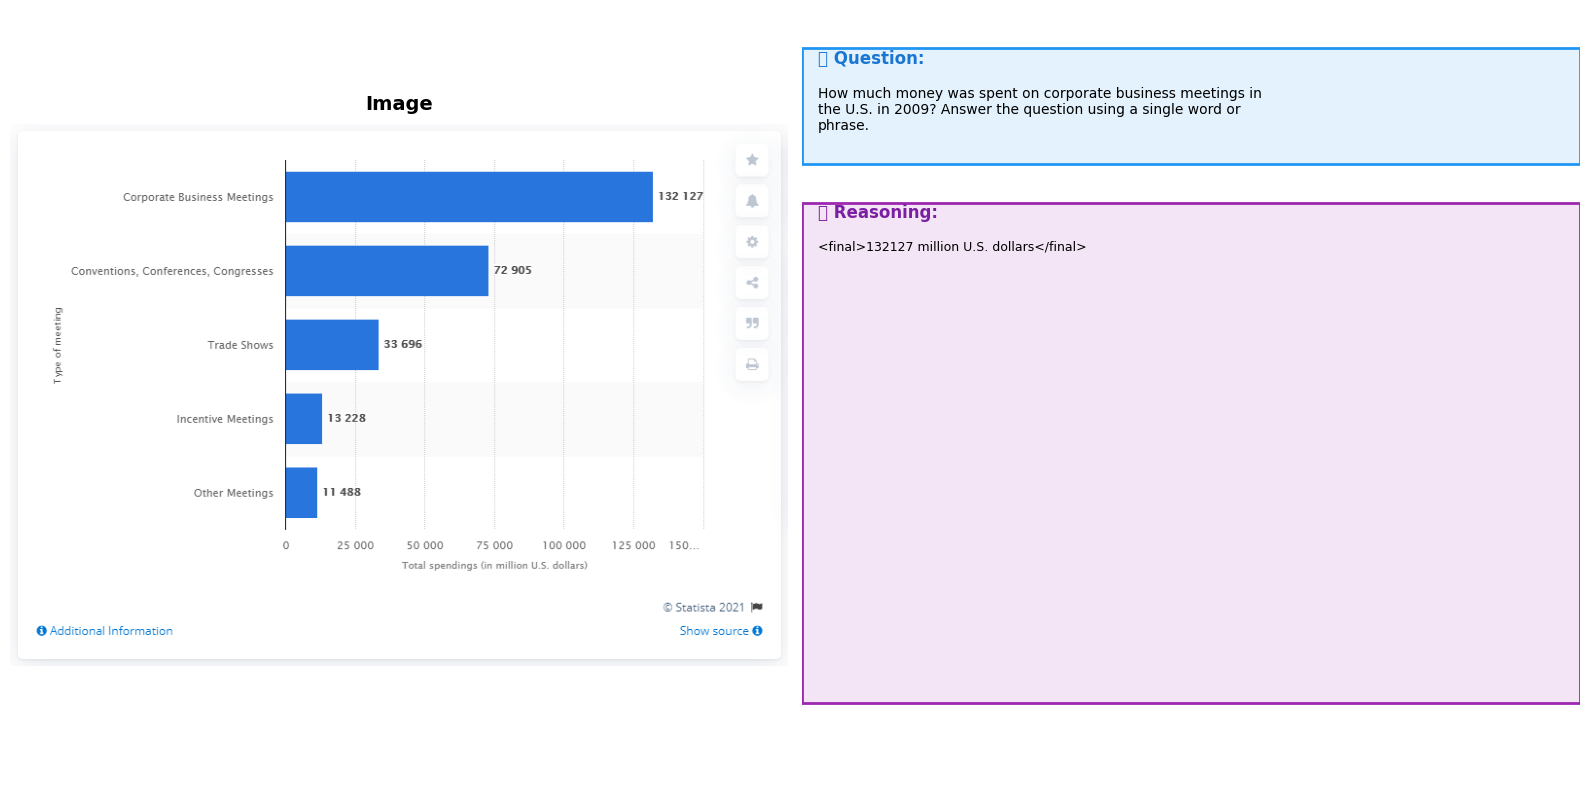

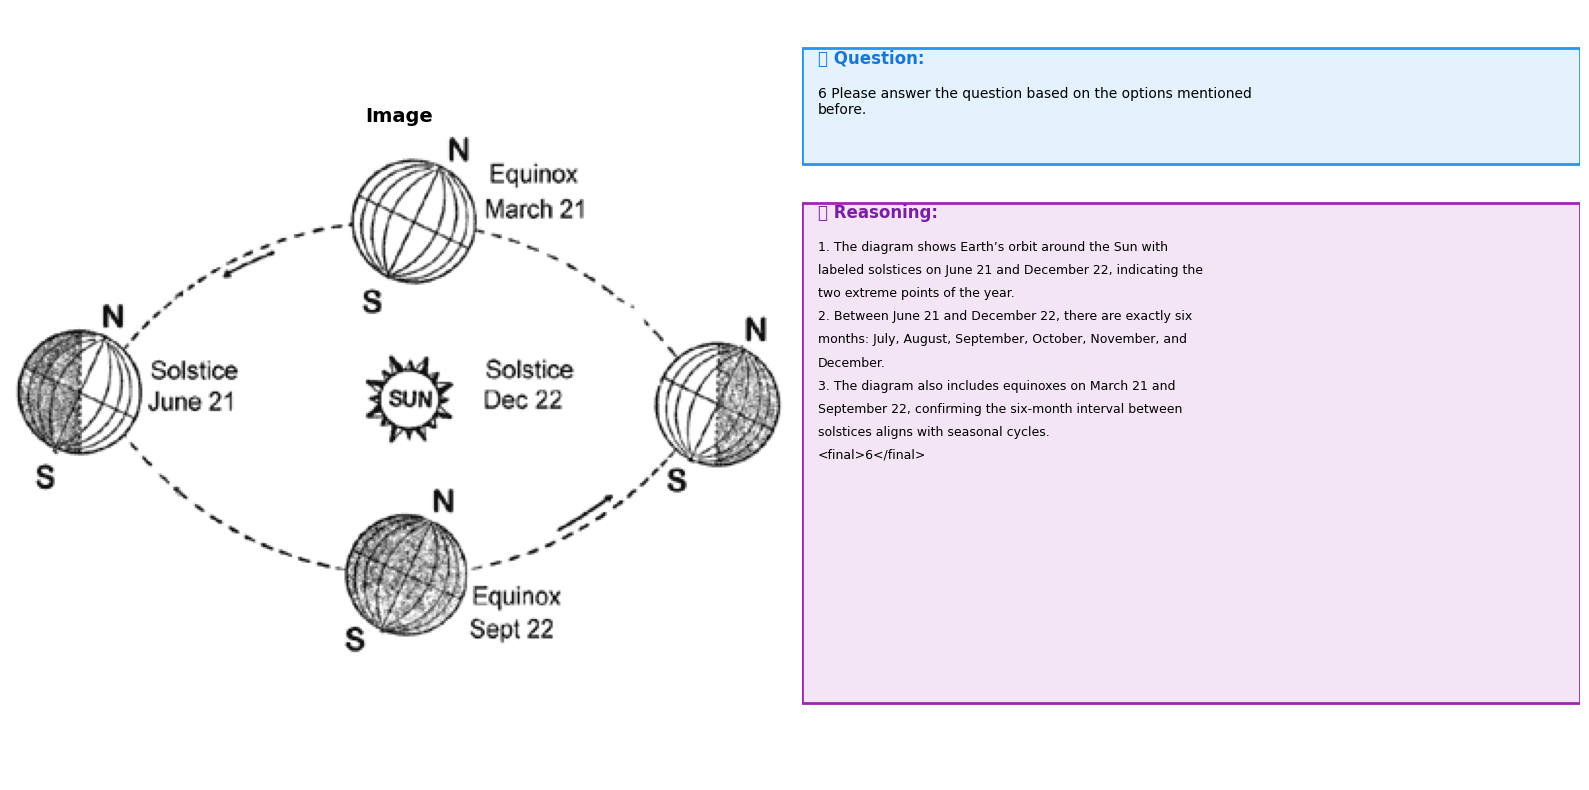

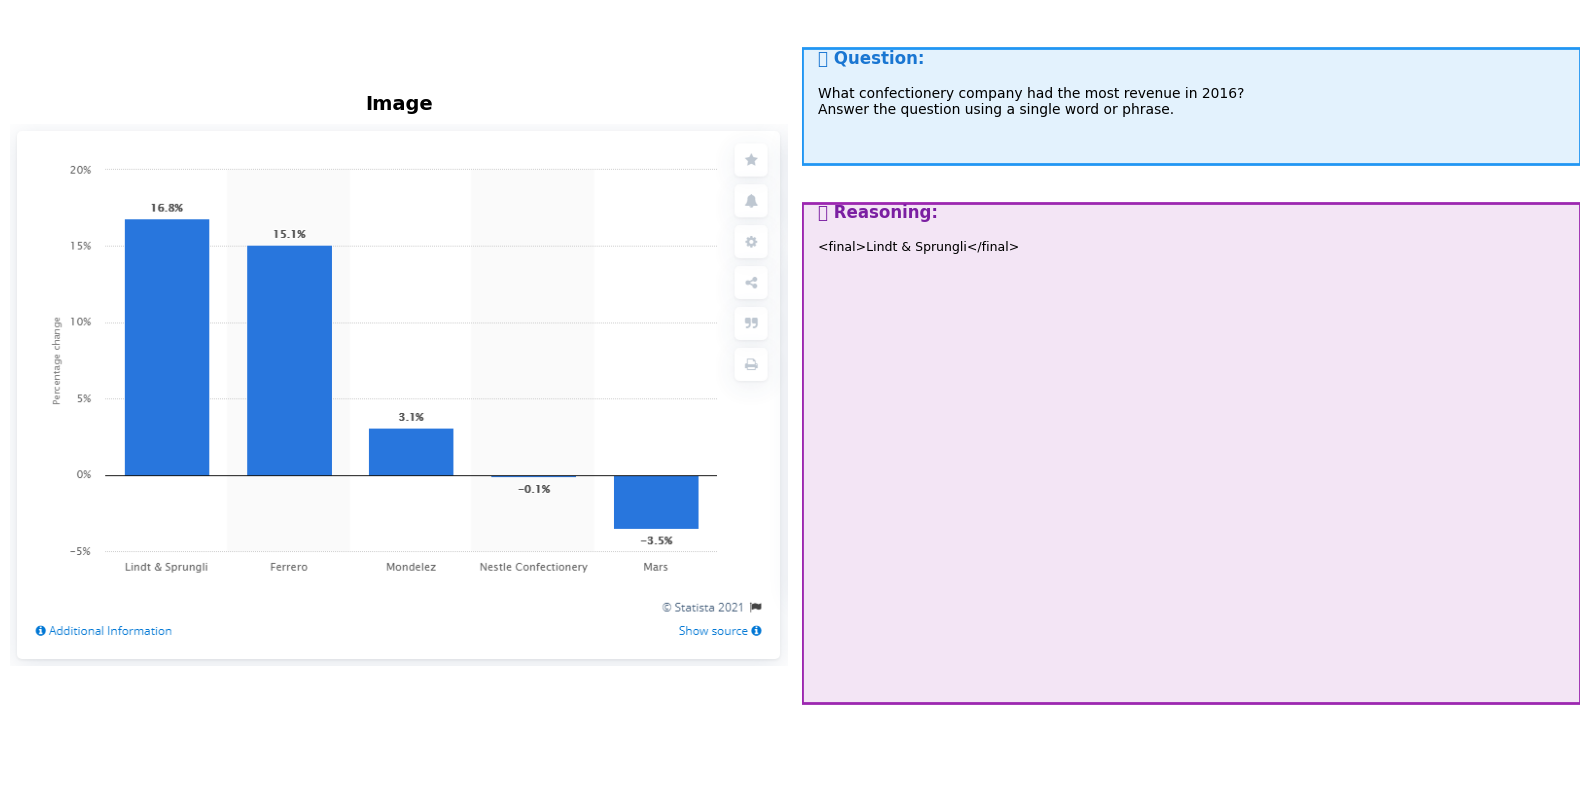

In [4]:
# 성공한 예제만 필터링
successful_files = []
for f in result_files:
    with open(f, 'r') as jf:
        data = json.load(jf)
        if 'error' not in data and data.get('successful_pairs', 0) > 0:
            successful_files.append(f)

print(f"성공한 예제: {len(successful_files)}개\n")

# 모든 성공한 예제 표시
for f in successful_files:
    display_result(f)

## 🔍 특정 예제 선택해서 보기

/tmp/ipykernel_2217262/2668886646.py:133: UserWarning: Glyph 10067 (\N{BLACK QUESTION MARK ORNAMENT}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_2217262/2668886646.py:133: UserWarning: Glyph 128173 (\N{THOUGHT BALLOON}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


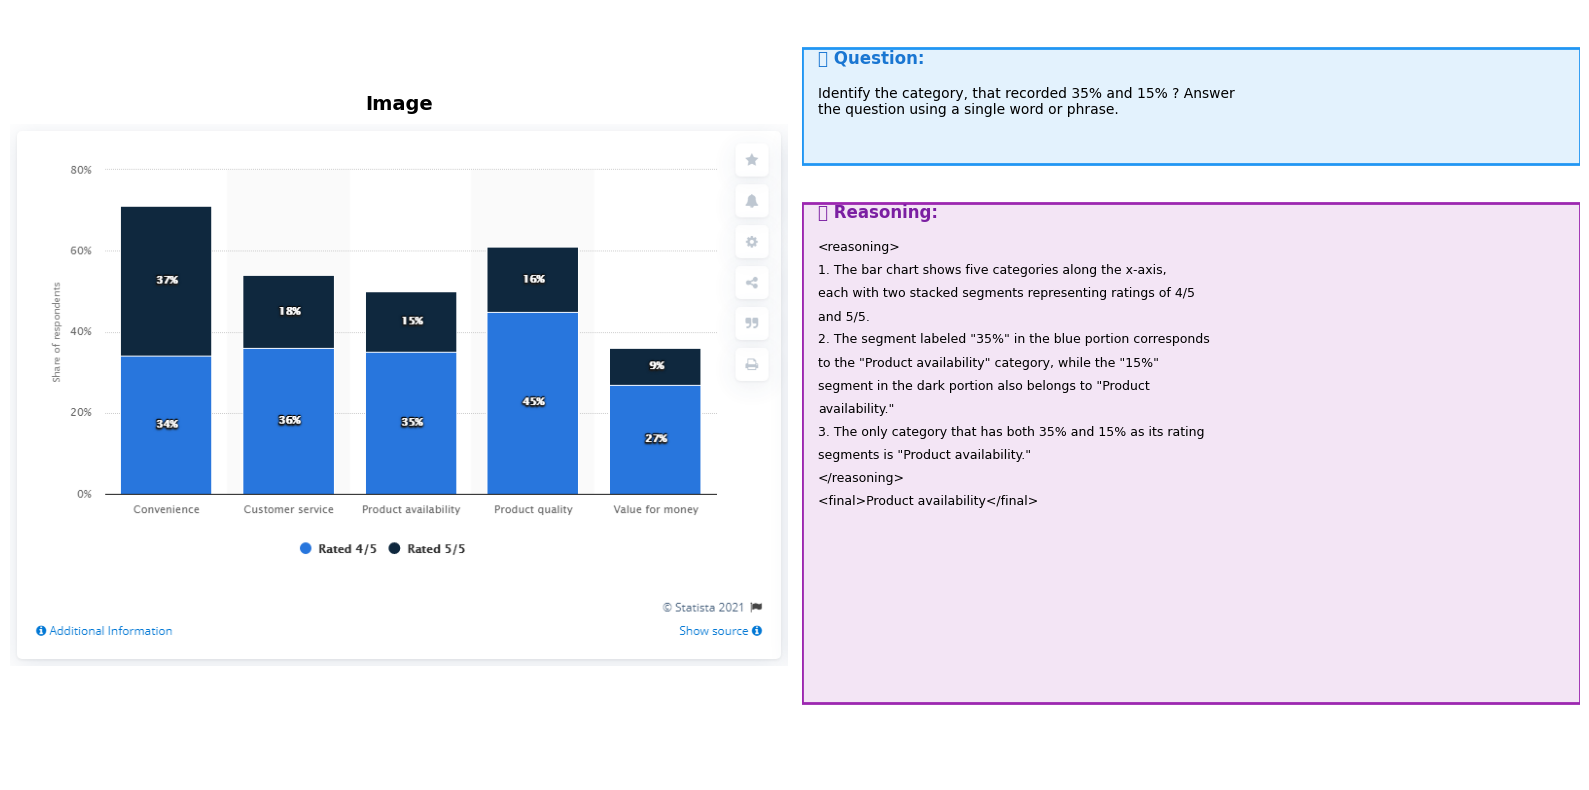

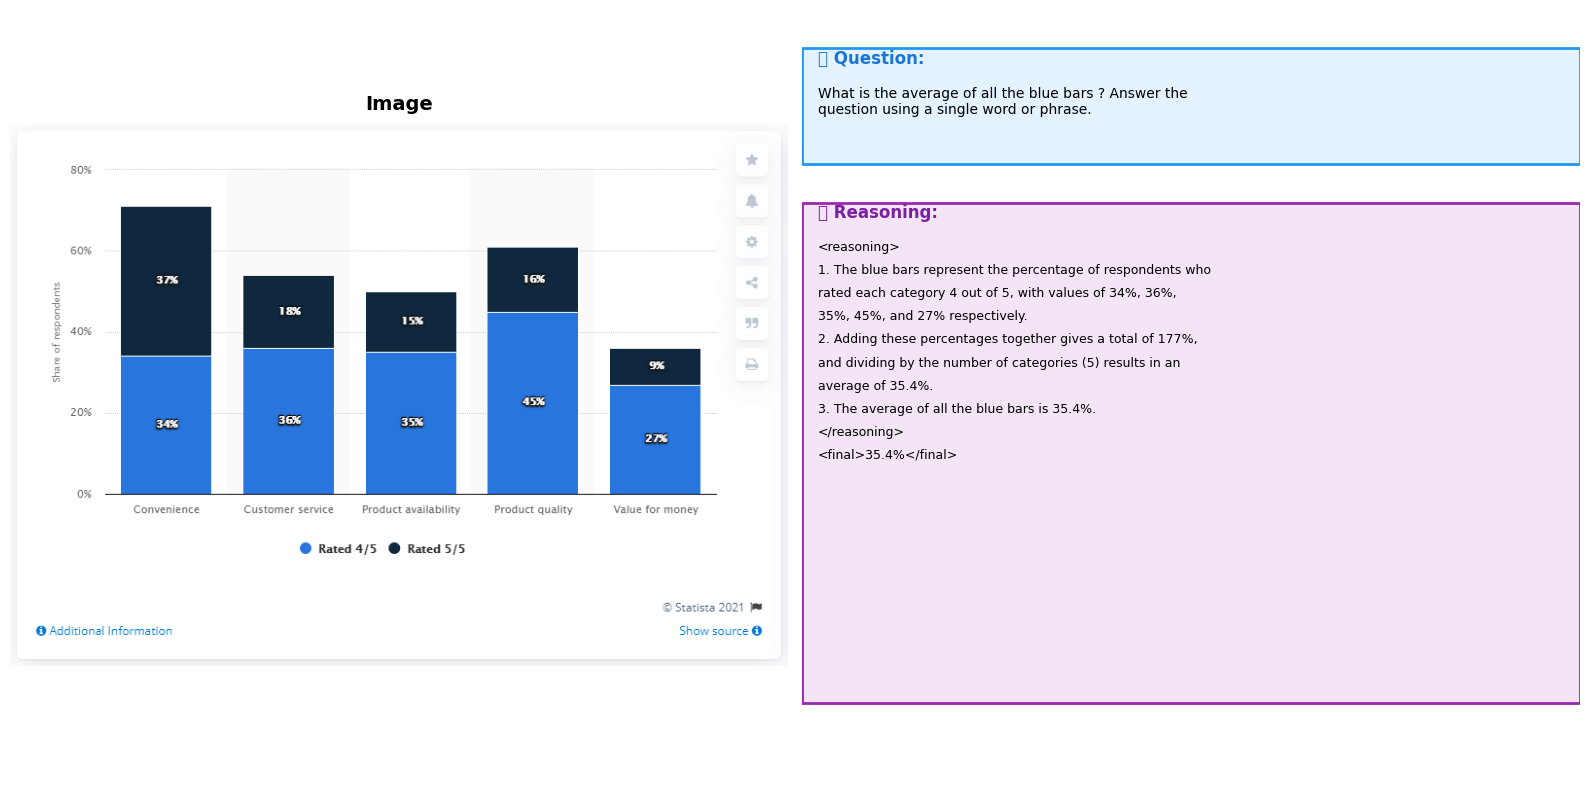

In [5]:
# 원하는 예제 번호 입력 (위의 목록에서 번호 확인)
example_number = 1  # 0, 1, 2, 3, ...

if example_number < len(result_files):
    display_result(result_files[example_number])
else:
    print(f"❌ 예제 {example_number}는 없습니다. 0-{len(result_files)-1} 사이로 선택하세요.")

## 📊 통계 요약

📈 전체 통계
총 파일: 10
성공: 5 ✅
에러: 5 ❌

Anchor Scores:
  - 총 점수 개수: 20
  - Non-zero 점수: 14
  - 평균: 11.30
  - 최소: 8.67
  - 최대: 14.85
  - 표준편차: 1.63


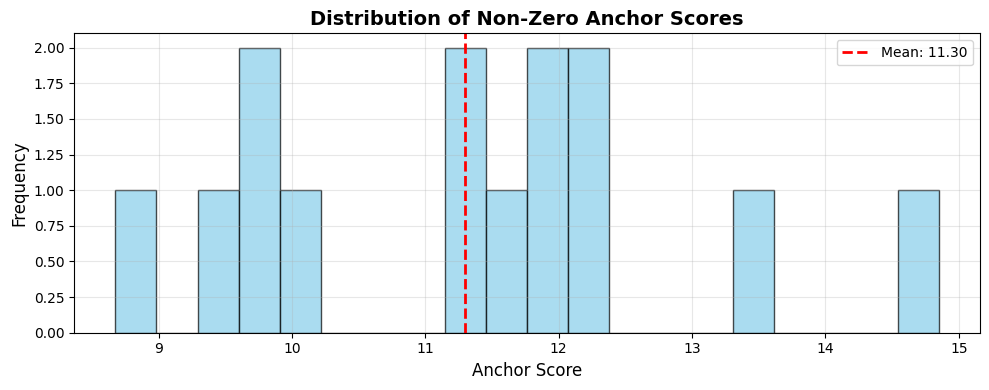

In [6]:
total_files = len(result_files)
successful = 0
errors = 0
all_anchor_scores = []

for f in result_files:
    with open(f, 'r') as jf:
        data = json.load(jf)
        if 'error' in data:
            errors += 1
        elif data.get('successful_pairs', 0) > 0:
            successful += 1
            for qa in data.get('qa_pairs', []):
                anchor_vec = qa.get('anchor_vector', [])
                if anchor_vec:
                    all_anchor_scores.extend(anchor_vec)

print("="*60)
print("📈 전체 통계")
print("="*60)
print(f"총 파일: {total_files}")
print(f"성공: {successful} ✅")
print(f"에러: {errors} ❌")
print()

if all_anchor_scores:
    scores = np.array(all_anchor_scores)
    non_zero = scores[scores > 0]
    
    print(f"Anchor Scores:")
    print(f"  - 총 점수 개수: {len(scores)}")
    print(f"  - Non-zero 점수: {len(non_zero)}")
    if len(non_zero) > 0:
        print(f"  - 평균: {non_zero.mean():.2f}")
        print(f"  - 최소: {non_zero.min():.2f}")
        print(f"  - 최대: {non_zero.max():.2f}")
        print(f"  - 표준편차: {non_zero.std():.2f}")
        
        # 히스토그램
        plt.figure(figsize=(10, 4))
        plt.hist(non_zero, bins=20, color='skyblue', edgecolor='black', alpha=0.7)
        plt.axvline(non_zero.mean(), color='red', linestyle='--', linewidth=2, 
                   label=f'Mean: {non_zero.mean():.2f}')
        plt.xlabel('Anchor Score', fontsize=12)
        plt.ylabel('Frequency', fontsize=12)
        plt.title('Distribution of Non-Zero Anchor Scores', fontsize=14, fontweight='bold')
        plt.legend()
        plt.grid(alpha=0.3)
        plt.tight_layout()
        plt.show()